In [2]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from sklearn.decomposition import PCA
import argparse
import pandas as pd

import sys  
sys.path.insert(1, '/home/stdi2687/gnss-leo-data/scripts')

from feature_extract_util import *

In [3]:
'''
ie = 1 = e region ionospheric scintillation
if = 2 = f region is
n =  3 = NO disturbance
o =  4 = oscillator anomoly
r1 =  5 = L1 rfi
r2 = 6 = L2 rfi
r = 7 = L1 + L2 RFI
a = 8 = suspected tracking/processing artifact
l = 9 = low SNR
d = 10 = unknown disturbance
'''
def class_map_binary(y):
    y_new=np.empty(len(y))
    y_new[y==1]=1
    y_new[y==2]=1
    y_new[y==3]=0
    y_new[y==4]=0
    y_new[y==5]=0
    y_new[y==6]=0
    y_new[y==7]=0
    y_new[y==8]=0
    y_new[y==9]=0
    y_new[y==10]=0
    return y_new

def class_map_multi(y):
    y_new=np.empty(len(y))
    y_new[y==1]=1
    y_new[y==2]=1
    y_new[y==3]=3
    y_new[y==4]=0
    y_new[y==5]=0
    y_new[y==6]=0
    y_new[y==7]=0
    y_new[y==8]=0
    y_new[y==9]=2
    y_new[y==10]=0
    return y_new

def get_meta_drop(df):
    times=df['time'].values
    lats=df["lat_m"].values
    occ_hts=df['occheight_m'].values
    X=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).values
    feature_names=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).columns
    return X, feature_names, times, lats, occ_hts

def df_2_Xy(df):
    #drop_cols=['time2', 'rfi_max','lat_m', 'lon_m', 'elevation_m', 'occheight_m','slip_L1', 'slip_L2',]
    drop_cols=[ 'rfi_max', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 'lat_m', 'lon_m', 'elevation_m', 'occheight_m', 'slip_L1', 'slip_L2']
    drop_cols=[ 'rfi_max', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 'lon_m', 'elevation_m', 'slip_L1', 'slip_L2']
    df=df.drop(columns=drop_cols)

    #Drop low SNR?
    #if "y_" in df:
    #    df = df[df["y_"] != 9]

    # Drop nans, inf, etc
    df=df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

    times=df['time'].values
    lats=df["lat_m"].values
    occ_hts=df['occheight_m'].values
    X=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).values
    feature_names=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).columns
    if "y_" in df:
        y_og=df["y_"]
        y_=class_map_binary(y_og)
        #y_=y_og
    else:
        y_=np.empty(X.shape[1])*np.nan

    return X, y_, times, lats, occ_hts, feature_names

In [4]:
label_df=pd.read_pickle('../data/converted_labels.pkl')
label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets/%s.pkl" %row[7:-8]
    
    try:
        fdf=pd.read_pickle(fn)
        if fdf.shape[1]==64:
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
full_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

X, y, times, lats, occ_hts, feature_names =df_2_Xy(full_fdf)

#---- split data
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train0, y_test0, lats_train, lats_test, hts_train, hts_test = train_test_split(X, y.ravel(), lats, occ_hts, test_size = 0.5, random_state = 20, stratify = y)

../data/feature_sets/2023.144.103.21.01.R05.SC001_0001.pkl 63


In [5]:
# comms link df
#label_df=pd.read_pickle('../data/converted_labels_scint.pkl')
label_df=pd.read_pickle('../data/converted_labels_scint_v2.pkl')

label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets/%s.pkl" %row
    
    try:
        fdf=pd.read_pickle(fn)
        if fdf.shape[1]==64:
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
comms_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

X, y, times, lats, occ_hts, feature_names =df_2_Xy(comms_fdf)

#---- split data
from sklearn.model_selection import train_test_split
X_trainC, X_testC, y_trainC, y_testC, lats_trainC, lats_testC, hts_trainC, hts_testC = train_test_split(X, y.ravel(), lats, occ_hts, test_size = 0.5, random_state = 20, stratify = y)


In [11]:
version="3-scint-test" # what does this mean?
print(X.shape, y.shape)
from collections import Counter
print("Class numbers check")
print(Counter(y.ravel()))


from sklearn.model_selection import GridSearchCV

#---- split data
# Split above!  Now merge comms and regular data:


#drop low snr from training but keep for testing!
#X_train=X_train[y_train!=9]
#y_train=y_train[y_train!=9]

# map to binary classes
#y_train=class_map_binary(y_train)
#y_test=class_map_binary(y_test)

def rf_model(X_train, y_train):
    #--- train models
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])
    parameters = { 
        'clf__n_estimators': [10, 100],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__max_depth' : [10,100, 1000],
        #'clf__criterion' : ['gini', 'entropy'],
        'clf__class_weight' : [None, 'balanced', 'balanced_subsample']
    }
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(pipeline, param_grid = parameters, cv = 5, n_jobs=20, scoring="f1")
    model.fit(X_train, y_train)

    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    #dump(model, '../models/%s_rf-model.joblib' %version)
    
    return model

def xgb_model(X_train, y_train):
    #--- train model
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBClassifier

    estimator = XGBClassifier(
        objective= 'binary:logistic',
        nthread=4,
        seed=42
    )
    parameters = {
        'max_depth': range (2, 10, 2),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }
    
    model = GridSearchCV(estimator, param_grid = parameters, cv = 5, n_jobs=20, scoring="f1")
    model.fit(X_train, y_train)

    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    #dump(model, '../models/%s_xgb-model.joblib' %version)

    return model

def svc_model(X_train, y_train):
    from sklearn.svm import SVC 
    from sklearn.model_selection import GridSearchCV 
  
    # defining parameter range 
    param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf']}  
    
    model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 5, n_jobs=20, scoring="f1") 
    # fitting the model for grid search 
    model.fit(X_train, y_train)
    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    #dump(model, '/home/kawu4468-copy/trained_models/rf-model.joblib')

    return model
  
for comms_test in ["new"]: #"old", 
    if comms_test=="old":
        X_train=X_train0
        y_train=y_train0

        X_test=X_test0
        y_test=y_test0
    if comms_test=="new":
        X_train=np.vstack([X_train0,X_trainC])
        y_train=np.concatenate((y_train0,y_trainC))

        X_test=X_test0
        y_test=y_test0
    #X_test=np.vstack([X_test0,X_testC])
    #y_test=np.concatenate((y_test0,y_testC))

    print(comms_test," train shape: ", y_train.shape, " sum: ", y_train.sum())
    print(comms_test," test shape: ", y_test.shape, " sum: ", y_test.sum())

    rf_model=rf_model(X_train, y_train)
    xgb_model=xgb_model(X_train, y_train)
    svc_model=svc_model(X_train, y_train)

    for model in [rf_model, xgb_model, svc_model]:
        #--- test model
        y_pred = model.predict(X_test)

        from sklearn.metrics import classification_report, confusion_matrix
        from sklearn.metrics import precision_recall_fscore_support
        print("\nConfusion matrix")
        print(confusion_matrix(y_test, y_pred))
        y = y[~np.isnan(X).any(axis=1)]
        X = X[~np.isnan(X).any(axis=1)]
        print(X.shape, y.shape)
        print("\nResult")
        print(classification_report(y_test, y_pred))

        print(precision_recall_fscore_support(y_test, y_pred))

(1070, 14) (1070,)
Class numbers check
Counter({0.0: 734, 1.0: 336})
new  train shape:  (5345,)  sum:  298.0
new  test shape:  (4810,)  sum:  131.0

Best: 0.605904 using {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
      0.554579 (0.070853) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 10}
      0.581213 (0.057449) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
      0.554579 (0.070853) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 10}
      0.581213 (0.057449) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
      0.554579 (0.070853) with: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__n_estimators': 10}
      0.581213 (0.057449) with: {'clf

In [ ]:
# test individual samples

In [32]:
#stdi2687/gnss-leo-data/figures/labeling_rfi/2023.016.135.20.01.G27.SC001_0001_features.png

#sample='2023.080.124.19.02.G10.SC001_0001' #clean
sample='2023.081.162.13.02.G05.SC001_0001'
#sample='2023.082.149.08.01.G18.SC001_0001' #phase and ampli
#sample='2023.080.149.18.01.G04.SC001_0001'
sample = '2022.321.135.22.01.G24.SC001_0001' #rfi and scint
sample= '2023.057.135.20.01.G01.SC001_0001'

fn='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
lv1=load_leo(fn)
fn='/media/datastore/mirror/spwxdp/repro4/spire/level2/scnLv2/%s/scnLv2_%s.0001_nc'%(sample[:8],sample)
lv2=load_leo(fn)

#plot_leo(sample, sp, lv2)
fdf=extract_fs(lv1,lv2)

In [33]:
X, y_, times, lats, occ_hts, feature_names=df_2_Xy(fdf)
#--- test model
y_pred = xgb_model.predict(X)
print(y_pred)

[1 1 0 0 0 0 0 0 0 0 0 0]


In [34]:
from matplotlib.patches import Rectangle
def plot_leo_ml(sample, ds, lv2, y_pred, times):

    c=299792458 #m/s
    #iono_free=((ds.scnfreq1**2)*(c/ds['exL1'])-(ds.scnfreq2**2)*(c/ds['exL2']))/(ds.scnfreq1**2-ds.scnfreq2**2)
    
    #ku=40.3*1e16
    #dTEC=(ds['exL2']-ds['exL1'])/(ku*(1/ds.scnfreq1**2-1/ds.scnfreq2**2))
    fig,ax=plt.subplots(6, figsize=(8,8),sharex=True)
    ax[0].set_title(sample)

    for freq,snr,color in zip([1,2],['caL1Snr','pL2Snr'],['#1b9e77','#d95f02']): 
        ax[0].plot(ds[snr].time+ds.startTime, ds[snr].values, alpha=.5, color=color, label='L%s'%freq)
        ax[0].set_ylabel('SNR' "\n" '(v/v)')

        ax[1].plot(lv2['s4_L%s'%freq].time+lv2.startTime, lv2['s4_L%s'%freq].values, color=color)
        ax[1].set_ylabel('S4')
        
        #ax[1].plot(ds['raw_exL%s'%freq].time, ds['raw_exL%s'%freq].values, color=color, label='L%s'%freq)
        #ax[1].set_ylabel(r'$\delta \phi$ (cycles)')
        ax[4].plot(lv2['elevation'].time+lv2.startTime, lv2['elevation'].values, color='black')
        ax[4].set_ylabel('elevation')
        ax2=ax[4].twinx()
        ax2.plot(ds['occheight'].time+ds.startTime, ds['occheight'].values, color='tab:orange')
        ax2.set_ylabel('occ height', color='tab:orange')

            
        ax[2].plot(ds['exL%s'%freq].time+ds.startTime, ds['exL%s'%freq].values, color=color, label='L%s'%freq)
        ax[2].set_ylabel(r'$\delta \phi$' "\n" '(m)')

        ax[3].plot(lv2['sigma_phi_L%s'%freq].time+lv2.startTime, lv2['sigma_phi_L%s'%freq].values, color=color)
        ax[3].set_ylabel(r'$\sigma \phi$' "\n" '(m)')
    #ax[3].plot(dTEC.time, dTEC.values)
    
    #ax[3].set_ylabel(r'$\Delta TEC$' "\n" '(TECU)')
    
    #ax[4].plot(iono_free.time, iono_free.values)
    #ax[4].set_ylabel('iono-free' "\n" '(m)')
    ax[0].legend(ncol=2)
    '''
    ## plot ml results
    df=pd.read_pickle('/home/kawu4468-copy/data_mat/spire_iq/rf_ml_ro.pkl')
    colors=['#e7298a','#d95f02','#7570b3','#1b9e77','#1b9e77','#66a61e','#e6ab02'] ##1b9e77
    labels=['scint', 'OA', 'dual int', 'quiet', 'quiet', 'l1 int', 'l2 int']
    fn_arr='scnPhs_%s.0001_ex.mat' %sample
    df=df[df.file==fn_arr]
    print(df['sample'])
    print(df.y_pred)
    [ax[5].add_patch(Rectangle((ds.time.min()+i*15, 0), 15, 1, alpha=.75, color= ,  label=labels[y-1])) for i, y in list(zip(df['sample'], df.y_pred))]
    '''
    [ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=1, label='No Scint', color="white")) for i in times[y_pred==0]]
    [ax[5].axvline(i) for i in times]
    [ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=.75, label='Scint')) for i in times[y_pred>0]]
    
    handles,labels=ax[5].get_legend_handles_labels() #get existing legend item handles and labels
    by_label = dict(zip(labels, handles))
    ax[5].legend(by_label.values(), by_label.keys(), ncol=4, loc='lower left')
    ax[5].get_yaxis().set_ticks([])
    ax[5].set_ylabel('RF Class')

    ax[5].set_xlim([times.min(), times.max()])

    #ax2=ax[5].twinx()
    #ax2.plot(ds['RFI'].orbtime-ds['RFI'].orbtime[0]+ds.startTime, ds['RFI'].values, color='tab:orange')
    #ax2.plot(hour_init+(ds['RFI'].orbtime-ds.startTime.values[0])/3600, ds['RFI'].values)
    #ax2.set_ylabel('RFI')
    #plt.savefig("../figures/results/%s.png" %sample, dpi=300)


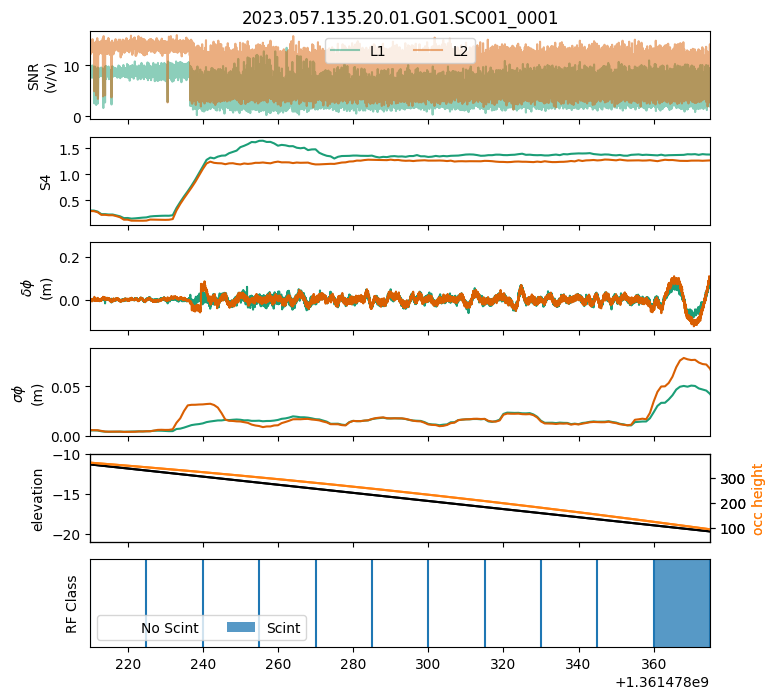

In [35]:
plot_leo_ml(sample, lv1, lv2, y_pred, times)

## compare with thresholds

In [12]:
# Make a plot to compare model testing performance with thresholds

#threshold
y_pred_thresh_s4=np.zeros(len(X_test))
y_pred_thresh_s4[(X_test[:,-4]>0.6)|(X_test[:,-3]>0.6)]=1

y_pred_thresh_sig=np.zeros(len(X_test))
y_pred_thresh_sig[(X_test[:,-2]>0.07)|(X_test[:,-1]>0.06)]=1

y_pred_rf = rf_model.predict(X_test)
y_pred_xgb=xgb_model.predict(X_test) 
y_pred_svc=svc_model.predict(X_test)

from sklearn.metrics import confusion_matrix
def metrics_confusion(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return TPR, FPR, ACC

# need to do this for L1 and L2?

met_li=[]
for name,y_metric in zip(["RF", "XGB", "SVC", "S4","Sigma Phi"],[y_pred_rf, y_pred_xgb, y_pred_svc, y_pred_thresh_s4, y_pred_thresh_sig]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_test, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_test, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)

[0.98680399 0.58862876]
[0.98290233 0.67175573] [0.32824427 0.01709767] [0.97442827 0.97442827]
[0.99106193 0.62162162]
[0.99529814 0.52671756] [0.47328244 0.00470186] [0.98253638 0.98253638]
[0.98950048 0.48167539]
[0.99700791 0.35114504] [0.64885496 0.00299209] [0.97941788 0.97941788]
[0.98160944 0.18779343]
[0.98674931 0.15267176] [0.84732824 0.01325069] [0.96403326 0.96403326]
[0.97440328 0.3434903 ]
[0.96409489 0.47328244] [0.52671756 0.03590511] [0.95072765 0.95072765]


In [13]:
df=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
df["Score"]=df.Score.astype(np.float16)

(0.0, 1.0)

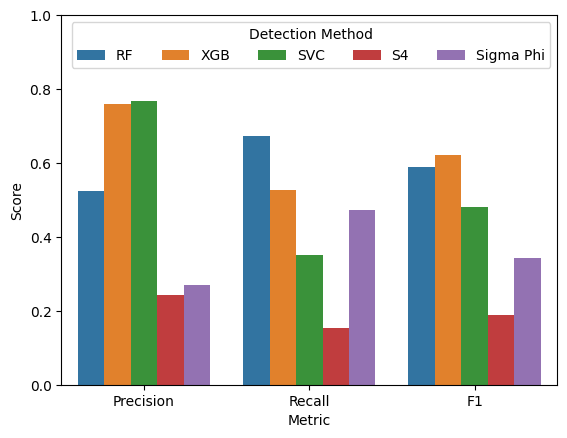

In [14]:
import seaborn as sns

fig,ax=plt.subplots()
ax=sns.barplot(df, x="Metric", y="Score", hue="Model")
ax.legend(loc='upper right',ncol=5, title="Detection Method")
ax.set_ylim([0,1])
#plt.savefig("../figures/compare_f1_v2.png", dpi=300)